In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests
from collections import Counter

In [2]:
#spy=pd.read_csv("data/SPY_weekly.csv")
#spy.rename(columns={'Adj Close':"adj_close"}, inplace=True)
#spy=spy.astype({'Date': 'datetime64'})

In [3]:
ticker='GDX'
d={'function': 'TIME_SERIES_WEEKLY_ADJUSTED','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker}
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [4]:
#open #high #low #close #adjusted close  #volume #dividend amount
spy=[[],[],[],[],[],[],[]]
for key, val in response.json()['Weekly Adjusted Time Series'].items():
    spy[0].append(float(val['1. open']))
    spy[1].append(float(val['2. high']))
    spy[2].append(float(val['3. low']))
    spy[3].append(float(val['4. close']))
    spy[4].append(float(val['5. adjusted close']))
    spy[5].append(float(val['6. volume']))
    spy[6].append(float(val['7. dividend amount']))

In [5]:
spy=pd.DataFrame({'Date':list(response.json()['Weekly Adjusted Time Series'].keys()),
                 'open':spy[0],
                  'high':spy[1],
                  'low':spy[2],
                  'close':spy[3],
                  'adj_close':spy[4],
                  'volume':spy[5],
                  'dividend':spy[6],
                 })
spy=spy.astype({'Date': 'datetime64'})


In [6]:
spy=spy.sort_values(by='Date')

In [7]:
spy.tail()

,Date,open,high,low,close,adj_close,volume,dividend
4,2020-03-27,21.63,27.2100,21.12,24.370,24.370,465945489.0,0.0
3,2020-04-03,24.39,25.8755,23.00,24.950,24.950,215608758.0,0.0
2,2020-04-09,26.01,28.9700,25.54,28.950,28.950,179418388.0,0.0
1,2020-04-17,28.65,32.2700,27.91,29.940,29.940,218237784.0,0.0
0,2020-04-22,29.98,32.4500,29.55,32.355,32.355,68943579.0,0.0


In [8]:
def return_percentile(x,window,t='latest',val=0):
    if t=='latest':
        x=x/x.shift(window)-1
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.nanpercentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.nanpercentile(np.sort(x),val)
        

### Returns

In [44]:
return_percentile(spy.adj_close,window=2)# 3 weeks of trading

(93.37, 0.11761658031088085)

In [10]:
return_percentile(spy.adj_close,window=1,t='val',val=5)

-0.08398270224949328

In [11]:
ret=(spy.adj_close/spy.adj_close.shift(1)-1).dropna()
pos=[]
for idx, r in enumerate(np.where(ret<-0.038,1,0)):
    if r==1:
        pos.append(idx)
l=[]
for i in range(1,len(pos)):
    l.append(pos[i]-np.roll(np.asarray(pos),1)[i])        

In [12]:
len(ret)-pos[-1]-1 # subtracting to adjust for indices 

6

In [13]:
#Counter(l)

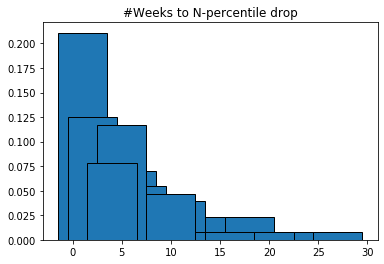

In [14]:
labels, values = zip(*Counter(l).items())
width = 5
plt.bar(labels, values/np.sum(values), width ,linewidth=1, edgecolor='black');
plt.title("#Weeks to N-percentile drop");

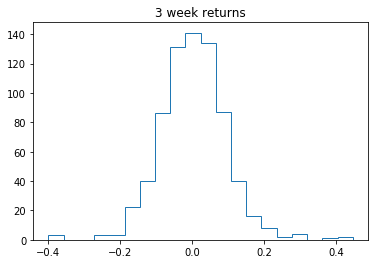

In [15]:
N=3
ret= (spy.adj_close/spy.adj_close.shift(N)-1).dropna()
plt.hist(ret, bins=20, histtype='step')
plt.title('{} week returns'.format(N));

In [16]:
ret.describe()

count    723.000000
mean       0.003993
std        0.091977
min       -0.398264
25%       -0.053013
50%        0.004007
75%        0.057161
max        0.445901
Name: adj_close, dtype: float64

### STD

In [61]:
get_percentile(spy.adj_close.rolling(3).apply(np.std, raw=False))

(79.28, 1.43008740991591)

In [18]:
get_percentile(spy.adj_close.rolling(4).apply(np.std, raw=False),t='val',val=90)

2.0829868768000352

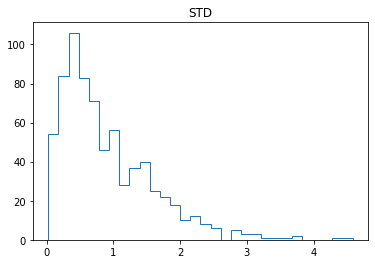

In [62]:
plt.hist(spy.adj_close.rolling(3
                              ).apply(np.std, raw=False), bins=30, histtype='step');
plt.title("STD");

### Sharpe Ratio

In [63]:
N=3
ret= (spy.adj_close/spy.adj_close.shift(N)-1).dropna()
std=spy.adj_close.rolling(N).apply(np.std, raw=False)
ret/std

0           NaN
1           NaN
2           NaN
3     -0.115006
4      0.067413
         ...   
721   -0.075940
722    0.160438
723    0.200752
724    0.105954
725    0.207535
Name: adj_close, Length: 726, dtype: float64

### STO

In [21]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':ticker,'interval':'weekly','fastkperiod':16 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

In [22]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })
sto=sto.astype({'Date': 'datetime64'})
sto['sto_diff']=sto['k']-sto['d']

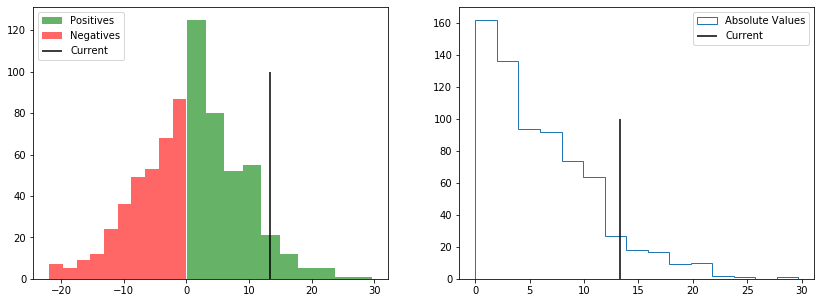

In [23]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(sto.sto_diff[sto.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [24]:
sto=sto.sort_values(by='Date')

In [25]:
get_percentile(sto.sto_diff)

(94.77, 13.3386)

In [64]:
get_percentile(sto.sto_diff, t='val', val=15)

-8.110869999999998

In [60]:
# Diff probably helps more on the downside
get_percentile(sto.sto_diff[sto.sto_diff>=0],t='val',val=90)

13.340039999999998

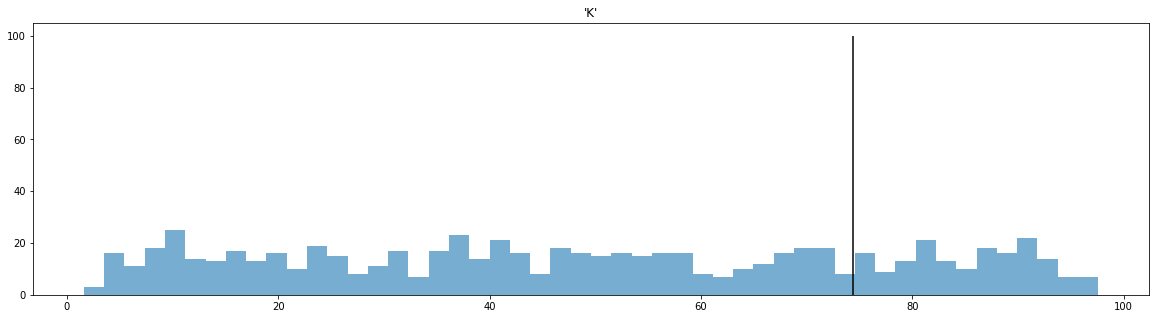

In [28]:
plt.figure(figsize=(20,5))
plt.title("'K'")
plt.vlines(sto.k[1],0,100)
plt.hist(sto.k, bins=50, alpha=0.6);


In [29]:
N=3
k_change=(sto.sort_values(by='Date').k/sto.sort_values(by='Date').k.shift(N)-1).dropna()

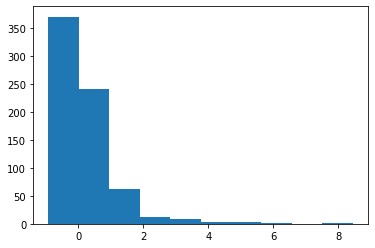

In [30]:
plt.hist(k_change);

In [31]:
get_percentile(k_change)

(87.07, 0.9564383302167514)

In [32]:
spy=spy.merge(sto,left_on='Date',right_on='Date',how='left')

In [56]:
spy['future_ret']=spy.adj_close.shift(-2)/spy.adj_close-1

In [65]:
vals=[[],[],[]]
upper_cut==5
lower_cut=-11
for index, row in spy.dropna().iterrows():
    if row.sto_diff<=upper_cut and row.sto_diff>=lower_cut:
        vals[0].append(row.Date)
        vals[1].append(row.sto_diff)
        vals[2].append(row.future_ret)

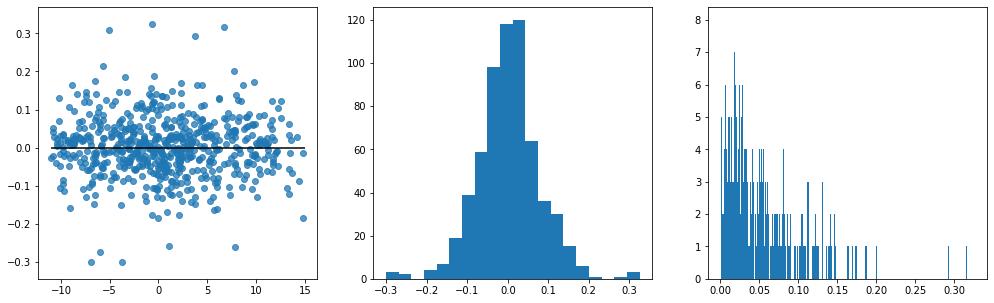

In [66]:
fig, ax = plt.subplots(1,3, figsize=(17,5))
ax[0].scatter(vals[1],vals[2], alpha=0.75)
ax[0].hlines(0,lower_cut,upper_cut);

ax[1].hist(vals[2], bins=20);
ax[2].hist(np.array(vals[2])[np.asarray(vals[2])>=0], bins=int(len(vals[2])/2));

In [67]:
np.sum([np.asarray(vals[2])>=-0.05])/len(vals[2]), len(vals[2])

(0.784, 625)

### MACD

In [37]:
#MACD & MACD/return diff slope

In [38]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [39]:
spy['macd']=macd
spy['macd_hist']=macd_hist

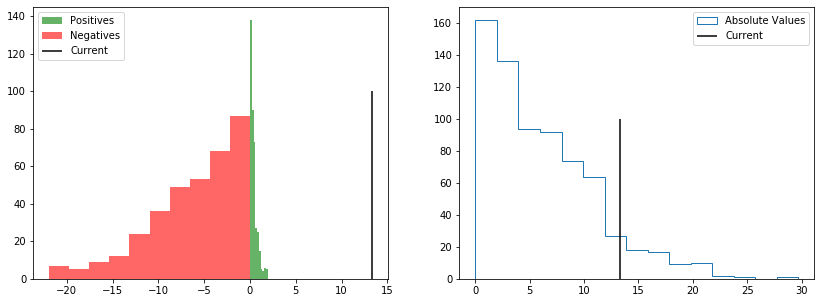

In [40]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(macd_hist[macd_hist>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
ax[0].hist(sto.sto_diff[sto.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
ax[0].vlines(sto.sto_diff[1],0,100 ,label='Current', color='black')
ax[0].legend(loc='upper left');

ax[1].hist(np.abs(sto.sto_diff), bins=15, histtype='step', label='Absolute Values');
ax[1].vlines(np.abs(sto.sto_diff[1]),0,100 ,label='Current')
ax[1].legend();

In [41]:
get_percentile(macd_hist)

(73.28, 0.31907172485040297)

### 20/50

In [42]:
spy

,Date,open,high,low,close,adj_close,volume,dividend,k,d,sto_diff,future_ret,macd,macd_hist
0,2006-06-02,39.50,39.7200,37.17,39.130,34.8133,1828400.0,0.0,NaN,NaN,NaN,-0.116536,0.000000,0.000000
1,2006-06-09,39.36,40.2700,33.62,35.130,31.2546,2858800.0,0.0,NaN,NaN,NaN,0.032734,-0.079843,-0.036595
2,2006-06-16,35.00,35.6300,31.82,34.570,30.7563,4296900.0,0.0,NaN,NaN,NaN,0.119468,-0.117188,-0.045081
3,2006-06-23,34.27,36.5000,33.57,36.280,32.2777,2363400.0,0.0,NaN,NaN,NaN,0.075798,-0.076371,-0.002918
4,2006-06-30,36.75,39.0600,35.00,38.700,34.4307,2844800.0,0.0,NaN,NaN,NaN,0.006976,0.033088,0.077594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,2020-03-27,21.63,27.2100,21.12,24.370,24.3700,465945489.0,0.0,32.1672,32.6119,-0.4447,0.187936,-0.714467,-0.970000
722,2020-04-03,24.39,25.8755,23.00,24.950,24.9500,215608758.0,0.0,45.4023,37.6669,7.7354,0.200000,-0.722350,-0.827440
723,2020-04-09,26.01,28.9700,25.54,28.950,28.9500,179418388.0,0.0,63.2822,46.9506,16.3316,0.117617,-0.401206,-0.428404
724,2020-04-17,28.65,32.2700,27.91,29.940,29.9400,218237784.0,0.0,74.3556,61.0134,13.3422,NaN,-0.066052,-0.078903


In [43]:
spy.adj_close.rolling(20).apply(np.mean, raw=False)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
721    27.041095
722    26.960965
723    27.079840
724    27.232330
725    27.511030
Name: adj_close, Length: 726, dtype: float64